In [41]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import random_split
from model2 import LPGCN
from generate_data2 import gen_data

In [42]:
### PARAMETERS ###
num_constraints = 7
num_variables = 5
batch_size = 2
learning_rate = 0.003
num_data = 10
out_func = 'obj'

device = device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs = 50

In [43]:
def train(train_data, val_data, out_func, epochs, num_constraints, num_variables):
    model = LPGCN(num_constraints, num_variables).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    val_loss = []

    def unpack_vars(data):
        c, A, b, constraints, l, u, sol, feas, edge_index = data
        c = c.to(device)
        A = A.to(device)
        b = b.to(device)
        constraints = constraints.to(device)
        l = l.to(device)
        u = u.to(device)
        sol = sol.to(device)
        return c, A, b, constraints, l, u, sol, feas, edge_index

    # optimize parameters and calculates training loss
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for dataloader in train_data:
            for batch in dataloader:
                optimizer.zero_grad()
                c, A, b, constraints, l, u, sol, feas, edge_index = unpack_vars(batch)
                out = model(c, A, b, constraints, l, u, edge_index, out_func)

                if out_func == 'feas':
                    loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]
                    # print(loss)

                elif out_func == 'obj':
                    loss = criterion(out[:,0], torch.sum(c * sol, dim=1))

                else:
                    loss = criterion(out, sol)

                if out_func != 'feas':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

        train_loss += [running_loss]

        # backup of optimized parameters
        if not os.path.exists(f'model_{out_func}_backups'):
            os.makedirs(f'model_{out_func}_backups')

        torch.save(model, f'model_{out_func}_backups/model_{out_func}_{epoch}.pt')
        
        # calculates validation error
        running_loss = 0.0

        for dataloader in val_data:
            for batch in dataloader:
                c, A, b, constraints, l, u, sol, feas, edge_index = unpack_vars(batch)
                out = model(c, A, b, constraints, l, u, edge_index, out_func)

                if out_func == 'feas':
                    loss = (out.shape[0] - torch.sum(torch.eq(out, feas))) / out.shape[0]

                elif out_func == 'obj':
                    loss = criterion(out[:,0], torch.sum(c * sol, dim=1))

                else:
                    loss = criterion(out, sol)

                running_loss += loss.item()

        val_loss += [running_loss]

    return train_loss, val_loss

In [44]:
train_set_obj = gen_data(int(num_data*0.7), batch_size, num_variables, num_constraints, out_func)

train_size = int(0.7 * len(train_set_obj))
validation_size = len(train_set_obj) - train_size

train_set_obj, val_set_obj = random_split(train_set_obj, [train_size, validation_size])

test_data_obj = gen_data(int(num_data*0.3), batch_size, num_variables, num_constraints, out_func)

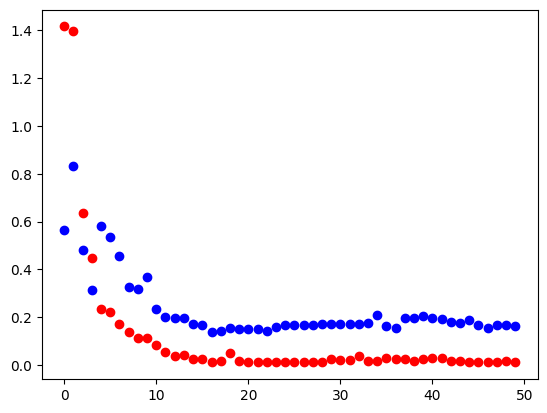

In [45]:
train_loss, val_loss = train(train_data_obj, val_data_obj, out_func, epochs, num_constraints, num_variables)


x = [i for i in range(epochs)]

plt.plot(x, train_loss, 'o', color='red')
plt.plot(x, val_loss, 'o', color='blue')
plt.show()

In [46]:
opt_idx = val_loss.index(min(val_loss))
opt_model = torch.load(f'model_{out_func}_backups/model_{out_func}_{opt_idx}.pt').to('cpu')
opt_idx

16

In [47]:
running_loss = 0.0
objs = []
for dataloader in test_data_obj:
    for batch in dataloader:
        c, A, b, constraints, l, u, sol, feas, edge_index = batch
        out = opt_model(c, A, b, constraints, l, u, edge_index, out_func)
        objs.append(torch.sum(c * sol, dim=1))
        loss = torch.mean(torch.square(out[:,0].T - torch.sum(c * sol, dim=1))) ** 1/2

        running_loss += loss.item()

running_loss / int(num_data*0.3)

0.009241427760571241

In [48]:
for dataloader in test_data_obj:
    for batch in dataloader:
        c, A, b, constraints, l, u, sol, feas, edge_index = batch
        out = opt_model(c, A, b, constraints, l, u, edge_index, out_func)
        print(out[0], torch.sum((c * sol)[0]))
        break

tensor([0.0370], grad_fn=<SelectBackward0>) tensor(-0.1330)
tensor([-0.1652], grad_fn=<SelectBackward0>) tensor(-0.1909)
tensor([0.1068], grad_fn=<SelectBackward0>) tensor(-0.0845)
